In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import env

# Acquire

#### After doing some research, some experimentation of performing actions and watching the logs, we discovered what each of the fields represent. We then parse and name the fields accordingly.

In [67]:
url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/curriculum_logs'
query = '''
SELECT date,
       path as endpoint,
       user_id,
       cohort_id,
       ip as source_ip
FROM logs;
'''
df = pd.read_sql(query, url)
print(df.shape)
df

(900223, 5)


,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...
900218,2021-04-21,jquery/personal-site,64,28.0,71.150.217.33
900219,2021-04-21,jquery/mapbox-api,64,28.0,71.150.217.33
900220,2021-04-21,jquery/ajax/weather-map,64,28.0,71.150.217.33
900221,2021-04-21,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


In [65]:
unique_endpoints = df['endpoint'].unique()
print(unique_endpoints)

['/' 'java-ii' 'java-ii/object-oriented-programming' ...
 'florence-python-assessment.html' 'javascript-i/dom'
 'appendix/professional-development/post-interview-review-form']


# Prepare
1. Convert `date` column to datetime class
2. Set `date` column as the index for the dataframe
3. Resample at a daily frequency using `count()` as the aggregation method

In [4]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

1. Label students by the program they are in.
2. Is it possible to identify the user_id of a staff member?
3. Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.
4. Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2.
5. Plot the access activity of these students.
**BONUS:** Can you identify users who are viewing both the web dev and data science curriculum?

<Axes: xlabel='date'>

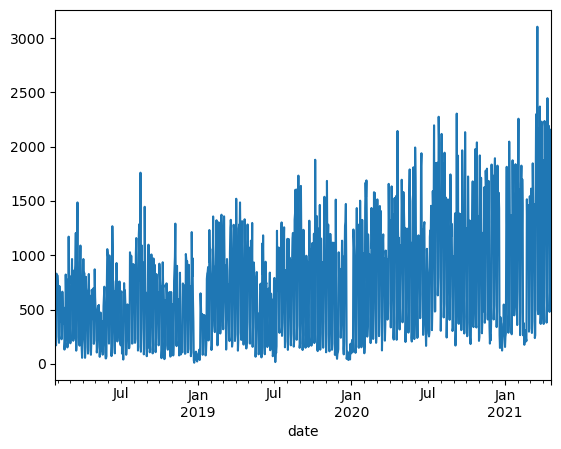

In [5]:
pages.plot()

There is no need to split because we are not modeling. We are only exploring to identify low probability cases.

### Exponential Moving Average

Simple Moving Average (SMA) time series are much less noisy than the time series of the original data points. The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. For datasets that contain rapid trend shifts, a SMA may simply be too slow to be useful.

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this:

## EMAt = (t0 * ( a / (1 + M))) + EMAt−1 * (1 - ( a / (1 + M)))

Where:

* t0 = Latest value
* t−1 = Previous value
* EMAt−1 = Exponential moving average of previous day.
* a = the smoothing constant (determines the degree of weight given to more recent values)
* M = Number of time periods, span of the window
> Note: The actual amount of weight given to the more recent values is determined by both the smoothing constant and M, the number of periods being evaluated. The shorter the time period, the more weight is given to more recent values.

Because the EMA formula is dependent on the previous time period's EMA, the first EMA is actually calculated as a simple moving average (SMA).

Instead of calculating EMA manually, we will use the pandas `ewm()` (Exponential Weighted functions) to compute our EMA. So we just need to define the following:

M = `span` = number of time periods. We will try 7 days, 14 days, and 30 days.

> There are other parameters that can be included in the function call that alters the weighting in various ways.

In [6]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
ema_7d.head()

date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: endpoint, dtype: float64

> Notice how there are no missing values. ewm() will use as many values as are available to compute the mean.
> So if the span is 7 days, but there is only one day of data available (i.e. the first day), the EMA will equal the first value.

In [7]:
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

In [8]:
# 14 day EMA
ema_14d = pages.ewm(span=14).mean()
ema_14d.head()

date
2018-01-26    572.000000
2018-01-27    388.785714
2018-01-28    305.208829
2018-01-29    465.757252
2018-01-30    514.347700
Freq: D, Name: endpoint, dtype: float64

In [9]:
# 30 day EMA
ema_30d = pages.ewm(span=30).mean()
ema_30d.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [10]:
# 90 day EMA
ema_90d = pages.ewm(span=90).mean()
ema_90d.head()

date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: endpoint, dtype: float64

> Remember! These are exponential moving averages, not simple! Notice that as the time period lengthens, the values begin to approximate a simple moving average.

In [11]:
# 900000000 day EMA
ema_90d = pages.ewm(span=900_000_000).mean()
ema_90d.head()

date
2018-01-26    572.0
2018-01-27    401.0
2018-01-28    324.0
2018-01-29    450.5
2018-01-30    490.8
Freq: D, Name: endpoint, dtype: float64

This ridiculously long EMA period has essentially created a SMA.

Lets plot our EMAs against each other:

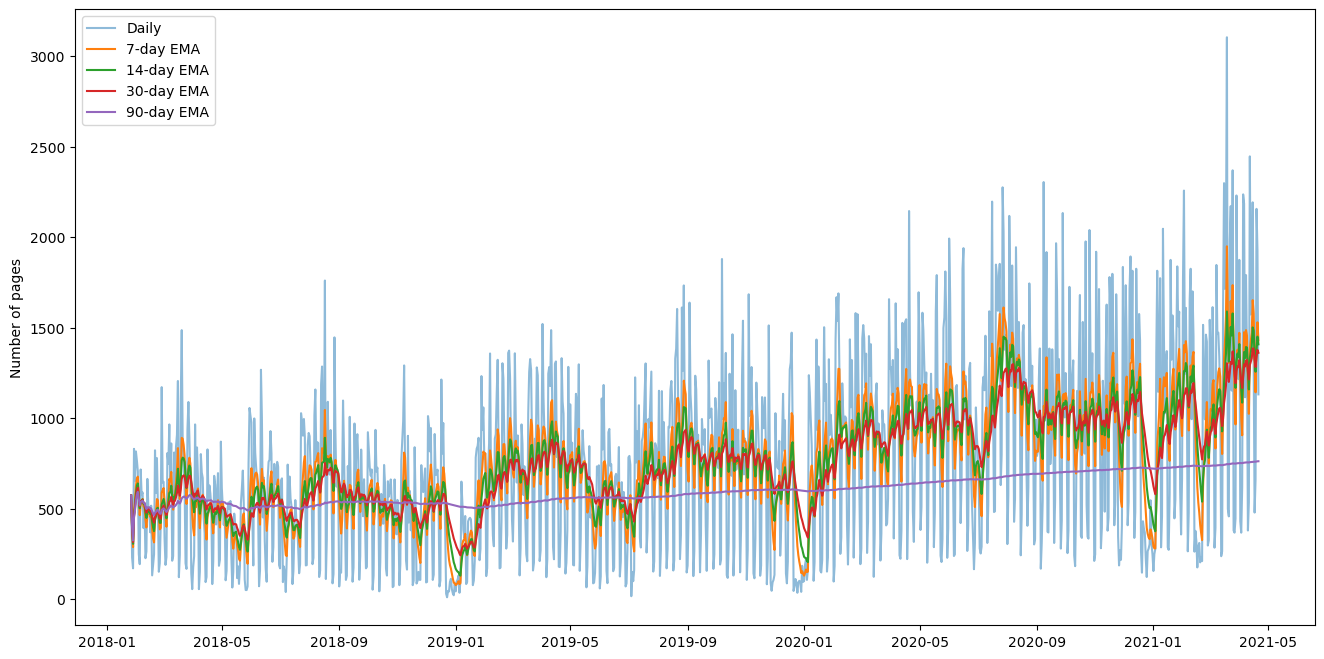

In [12]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

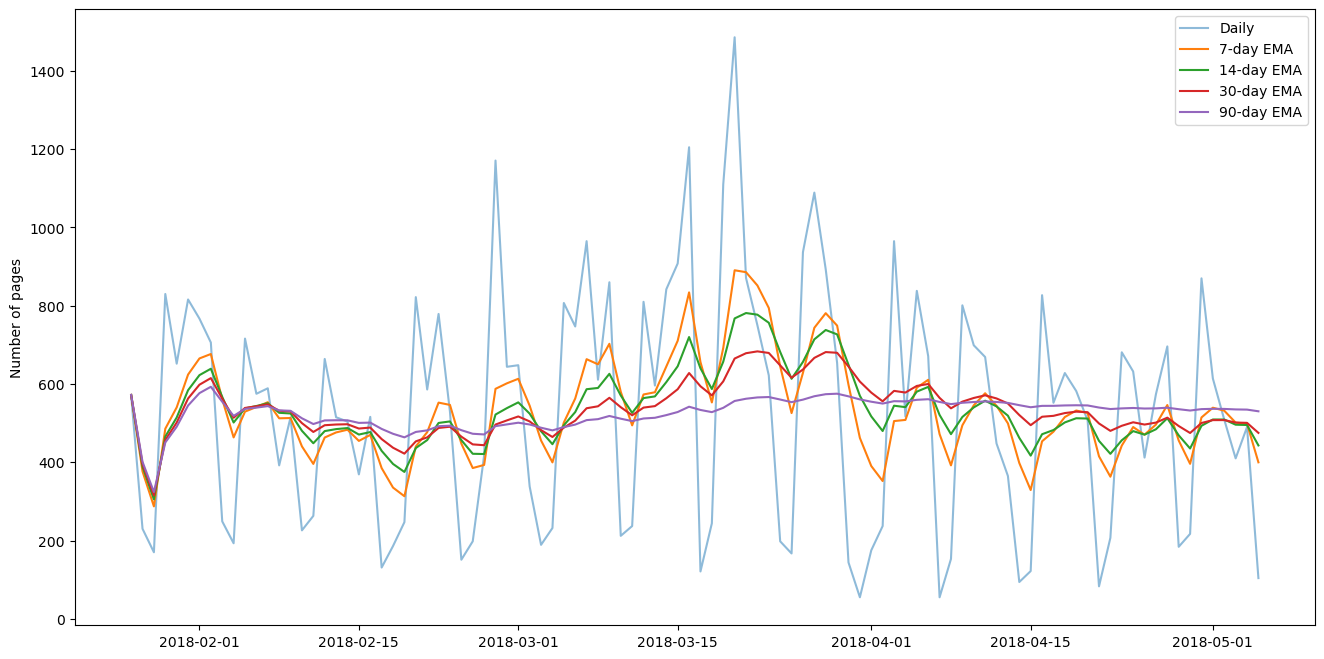

In [13]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(pages.index[:100], pages[:100], label='Daily', alpha=.5)
ax.plot(pages.index[:100], ema_7d[:100], label = '7-day EMA')
ax.plot(pages.index[:100], ema_14d[:100], label = '14-day EMA')
ax.plot(pages.index[:100], ema_30d[:100], label = '30-day EMA')
ax.plot(pages.index[:100], ema_90d[:100], label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

## Bollinger Bands

A volatility indicator commonly used in stock market, forex, and cryptocurrency trading.
Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.
Based on the exponential moving average
### Midband

The Exponential Moving Average

midband = train.ewm(span=30).mean()

### Upper & Lower Band

UB/LB = Midband +/- stdev * K

stdev = train.ewm(span=30).std()

K = the number of standard deviations to go up and down from the EMA

### %b, Percent Bandwidth

Shows where the last value sits in relation to the bands.

%b = last−LB / UB-LB

If %b > 1, data point lies above the upper band
If %b < 0, data point lies below the lower band
If %b == .5, data point lies on the midband.
### Bandwidth

The width of the bands

Bandwidth = (UB-LB) / midband

In [14]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [15]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [21]:
# compute upper and lower bands
ub = midband + stdev*2
lb = midband - stdev*2
ub, lb

(date
 2018-01-26            NaN
 2018-01-27     878.961038
 2018-01-28     742.895854
 2018-01-29    1089.938060
 2018-01-30    1070.328518
                  ...     
 2021-04-17    2805.204187
 2021-04-18    2751.889069
 2021-04-19    2825.623313
 2021-04-20    2845.064711
 2021-04-21    2786.355225
 Freq: D, Name: endpoint, Length: 1182, dtype: float64,
 date
 2018-01-26           NaN
 2018-01-27    -88.361038
 2018-01-28   -112.616698
 2018-01-29   -175.933288
 2018-01-30    -67.590389
                  ...    
 2021-04-17   -154.845956
 2021-04-18   -187.489435
 2021-04-19   -148.475267
 2021-04-20    -91.603636
 2021-04-21    -64.601316
 Freq: D, Name: endpoint, Length: 1182, dtype: float64)

In [22]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,878.961038,-88.361038
2018-01-28,742.895854,-112.616698
2018-01-29,1089.938060,-175.933288
2018-01-30,1070.328518,-67.590389


In [23]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,878.961038,-88.361038
2018-01-28,170,315.139578,742.895854,-112.616698
2018-01-29,830,457.002386,1089.938060,-175.933288
2018-01-30,652,501.369064,1070.328518,-67.590389


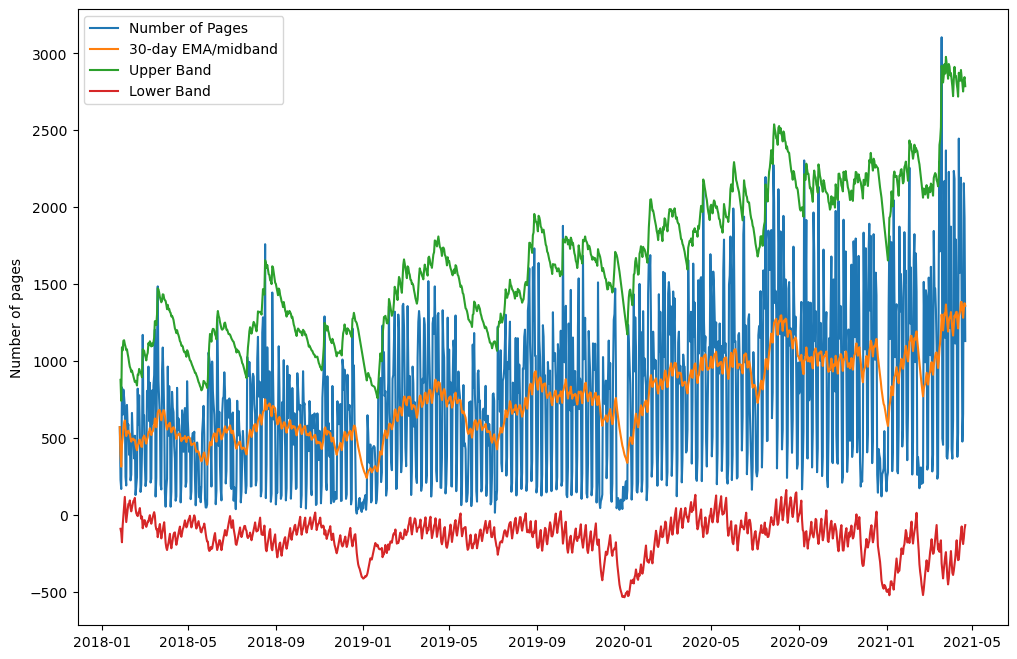

In [24]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

## Compute %b
Each data point will have a %b value that represents its relative position within/around the bollinger bands. It answers the question: Where does this point sit relative to a simple range of expected values?

Lets manually compute %b for the last value in the dataset:

In [20]:
# Visualize the last record in our dataset
my_df.iloc[-1]

pages      1131.000000
midband    1360.876954
ub         3499.094360
lb         -777.340451
Name: 2021-04-21 00:00:00, dtype: float64

In [25]:
# get the value of the last record
last_measure = my_df.iloc[-1].pages
last_measure

1131.0

In [26]:
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
last_lb

-64.60131597531722

In [27]:
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
last_ub

2786.355224664969

In [28]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.42


In [29]:
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,878.961038,-88.361038,0.329116
2018-01-28,170,315.139578,742.895854,-112.616698,0.330348
2018-01-29,830,457.002386,1089.938060,-175.933288,0.794657
2018-01-30,652,501.369064,1070.328518,-67.590389,0.632374


In [30]:
my_df[my_df['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,
2018-02-27,1171,496.375166,1077.905985,-85.155652,1.080042
2018-03-20,1486,665.021495,1472.918024,-142.875035,1.008096
2018-05-30,1056,400.137163,1018.214066,-217.939741,1.030567
2018-07-23,1027,435.495343,1010.366096,-139.375411,1.014468
2018-08-17,1760,751.910516,1655.512283,-151.691251,1.057817
2018-11-08,1291,561.449002,1248.899313,-126.001309,1.030621
2019-01-28,1232,447.643274,1168.205223,-272.918675,1.044267
2019-07-08,1225,479.213223,1215.420161,-256.993715,1.006506
2019-10-07,1879,803.738383,1792.312562,-184.835797,1.043845


In [31]:
def acquire_logs(user=env.username, password=env.password, host=env.host):
    '''
    This function queries the Codeup MySQL curriculum_logs database and returns a dataframe
    '''
    url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/curriculum_logs'
    query = '''
    SELECT date,
           path as endpoint,
           user_id,
           cohort_id,
           ip as source_ip
    FROM logs;
    '''
    df = pd.read_sql(query, url)
    return df

In [32]:
def one_user_df_prep(df, user):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages_one_user = df['endpoint'].resample('d').count()
    return pages_one_user

In [33]:
def compute_pct_b(pages_one_user, span, weight, user):
    '''
    This function adds the %b of a bollinger band range for the page views of a single user's log activity
    '''
    # Calculate upper and lower bollinger band
    midband = pages_one_user.ewm(span=span).mean()
    stdev = pages_one_user.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    # Add upper and lower band values to dataframe
    bb = pd.concat([ub, lb], axis=1)
    
    # Combine all data into a single dataframe
    my_df = pd.concat([pages_one_user, midband, bb], axis=1)
    my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
    
    # Calculate percent b and relevant user id to dataframe
    my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

In [34]:
def plot_bands(my_df, user):
    '''
    This function plots the bolliger bands of the page views for a single user
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_user, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

In [35]:
def find_anomalies(df, user, span, weight, plot=False):
    '''
    This function returns the records where a user's daily activity exceeded the upper limit of a bollinger band range
    '''
    
    # Reduce dataframe to represent a single user
    pages_one_user = one_user_df_prep(df, user)
    
    # Add bollinger band data to dataframe
    my_df = compute_pct_b(pages_one_user, span, weight, user)
    
    # Plot data if requested (plot=True)
    if plot:
        plot_bands(my_df, user)
    
    # Return only records that sit outside of bollinger band upper limit
    return my_df[my_df.pct_b>1]

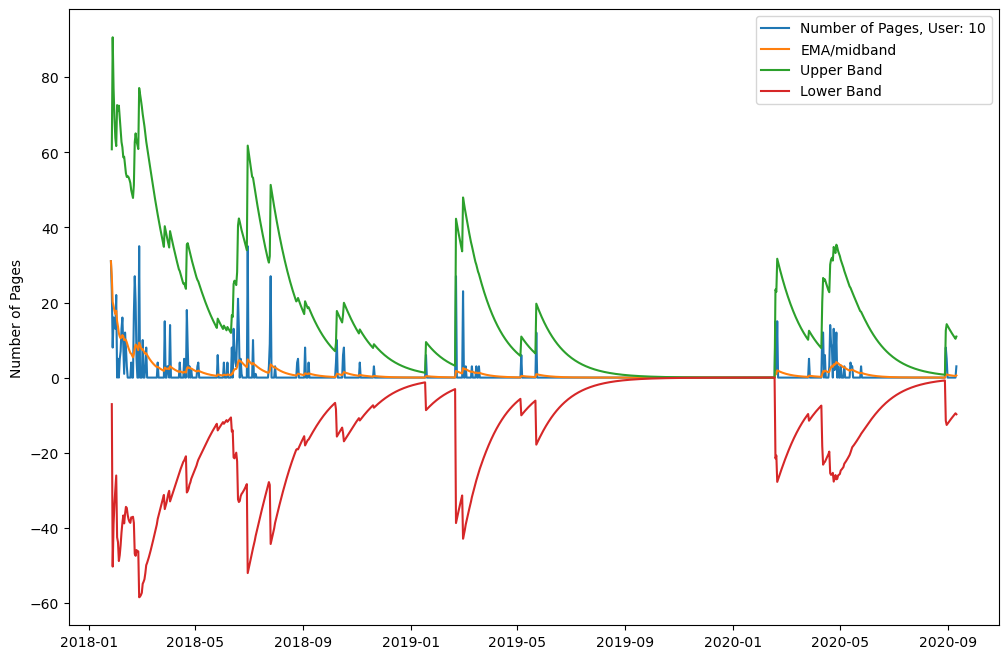

In [38]:
# Test functions
user = 10
span = 30
weight = 6
user_df = find_anomalies(df, user, span, weight, plot=True)

anomalies = pd.DataFrame()
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)

In [40]:
anomalies.head()

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,


In [51]:
span = 30
weight = 3

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [50]:
anomalies

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,


In [52]:
anomalies.sort_values(by='pct_b', ascending=False)

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2020-05-12,16,1.032258,13.026013,-10.961497,1.123981,93
2020-03-10,8,0.516129,6.513006,-5.480748,1.123981,213
2020-09-13,4,0.258065,3.256503,-2.740374,1.123981,210
2021-01-19,4,0.258065,3.256503,-2.740374,1.123981,308
2020-12-24,1,0.064516,0.814126,-0.685094,1.123981,232
...,...,...,...,...,...,...
2020-10-17,5,0.531820,4.994405,-3.930765,1.000627,564
2020-09-03,62,12.512145,61.945338,-36.921047,1.000553,737
2018-08-10,107,16.939655,106.913987,-73.034677,1.000478,223


In [53]:
anomalies.sort_values(by='pages_one_user', ascending=False)

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2020-07-22,285,44.915959,266.290617,-176.458698,1.042257,11
2019-03-03,272,24.721632,232.200343,-182.757078,1.095913,341
2020-04-16,271,44.194413,267.834945,-179.446120,1.007076,570
2019-07-25,253,34.698961,222.709718,-153.311796,1.080555,422
2020-04-05,232,32.133967,205.731770,-141.463837,1.075658,570
...,...,...,...,...,...,...
2020-05-13,1,0.073714,0.935518,-0.788090,1.037411,366
2019-12-27,1,0.064516,0.814126,-0.685094,1.123981,63
2020-04-10,1,0.086758,0.979035,-0.805520,1.011748,367


In [54]:
anomalies.user_id.value_counts()

88     21
41     18
80     18
146    18
291    16
       ..
251     1
663     1
243     1
240     1
927     1
Name: user_id, Length: 610, dtype: int64

<Axes: xlabel='date'>

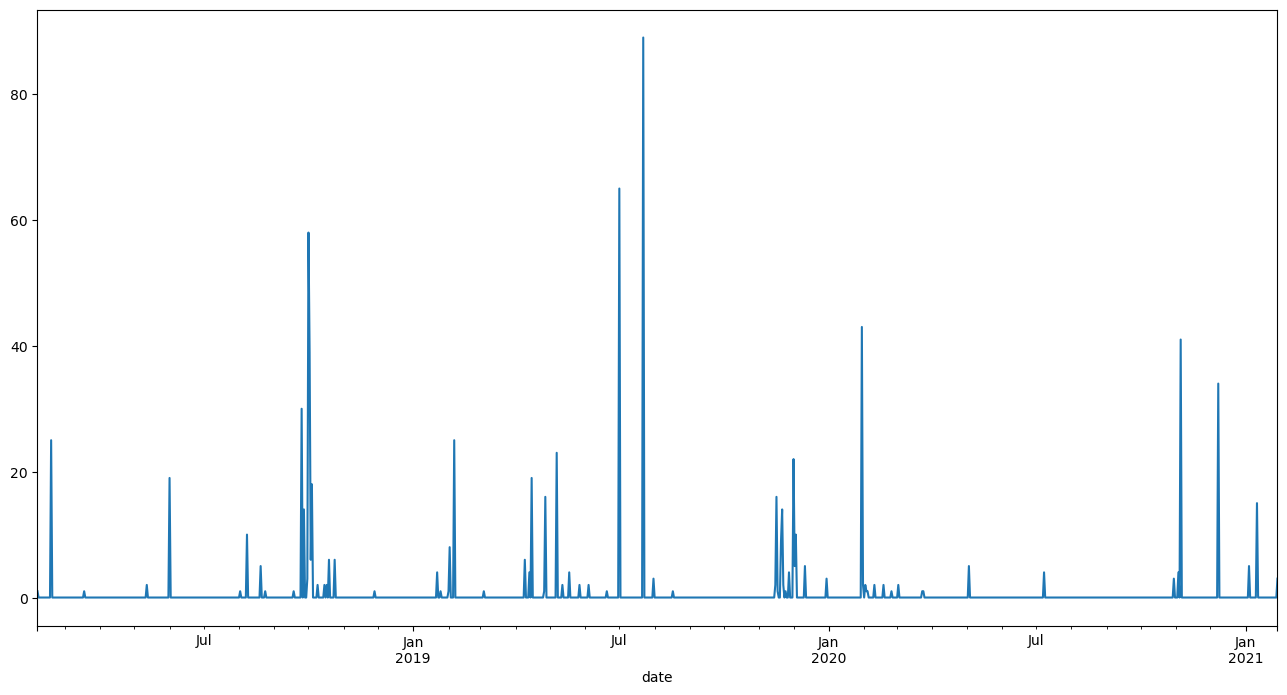

In [55]:
df_88 = one_user_df_prep(df, 88)
df_88.plot(figsize=(16,8))